In [1]:
import os
import glob
import re
import functools
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import cv2

import data_io
import u_net

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

tf.__version__

'2.0.0-alpha0'

# Set up

In [3]:
common_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/plate_2017017086_ki67'
# common_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/p2017017086_ki67_merge'

img_dir = os.path.join(common_root, 'images')
mask_dir = os.path.join(common_root, 'masks')

batch_size = 5
task = 'nuc_seg'

In [4]:
if task == 'nuc_seg':
    x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-2.png'))) # nucleus images
    y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_nucleus.png'))) # nucleus masks     

elif task == 'cell_seg':
    x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-3.png'))) # cell images
    y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_cell.png'))) # cell masks
    
elif task == 'both_seg':
    x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*.png'))) # merged images
    y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*.png'))) # merged masks, green: nucleus, red: cell
    
else:
    raise ValueError('Unknown task.')

# Remove column 2
pattern = re.compile('_[A-Z]2_')
x_train_fnames = [f for f in x_train_fnames if not pattern.search(f)]
y_train_fnames = [f for f in y_train_fnames if not pattern.search(f)]

# idx = np.random.choice(len(x_train_fnames))
# print(x_train_fnames[idx])
# print(y_train_fnames[idx])

# Split into training and validation
x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = \
    train_test_split(x_train_fnames, y_train_fnames, test_size=0.2, random_state=43)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

Number of training samples: 345
Number of validation samples: 87


In [ ]:
idx = np.random.choice(num_val_data)
print(os.path.basename(x_val_fnames[idx]))
print(os.path.basename(y_val_fnames[idx]))

# Test the input pipeline

### Get image and mask from path names

In [ ]:
idx = np.random.choice(num_train_data)
img, mask = data_io._get_image_from_path(x_train_fnames[idx], y_train_fnames[idx], 
                                         max_level=4095., channels=1)

print('Image shape: {}'.format(img.shape))
print('Mask shape : {}'.format(mask.shape))

# single channel
plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

# color
# plt.figure(figsize=(12,16))
# plt.subplot(1,2,1)
# plt.imshow(img, cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(mask)

In [ ]:
print(np.unique(mask))

print(img.shape)
print(img.dtype)
print(mask.shape)
print(img.numpy().max())

### Test the input pipeline

In [ ]:
import importlib
importlib.reload(data_io)
importlib.reload(u_net)

In [ ]:
read_img_fn = functools.partial(data_io._get_image_from_path, max_level=4095., channels=1)
tmp_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, read_img_fn=read_img_fn)

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(tmp_ds.shuffle(num_train_data).take(3)):
    print(img.numpy().max())
    print(mask.numpy().max())
    plt.subplot(3,2,2*i+1)
    plt.imshow(img[0,:,:,0]/255.)
    plt.subplot(3,2,2*i+2)
    plt.imshow(mask[0,:,:,0]/255.)
plt.show()

# Configure training and validation datasets

In [5]:
read_img_fn = functools.partial(data_io._get_image_from_path, max_level=4095., channels=1)

# training data
train_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512],
    'to_flip': True
}
tr_preproc_fn = functools.partial(data_io._augment, **train_cfg)

# validation data
val_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512]
}
val_preproc_fn = functools.partial(data_io._augment, **val_cfg)

train_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, read_img_fn=read_img_fn,
                               preproc_fn=tr_preproc_fn, shuffle=True, batch_size=batch_size)
val_ds = data_io.get_dataset(x_val_fnames, y_val_fnames, read_img_fn=read_img_fn, 
                             preproc_fn=val_preproc_fn, shuffle=False, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(val_ds.take(3)):

    plt.subplot(3,3,3*i+1)
    plt.imshow(img[0,:,:,0])
    
    plt.subplot(3,3,3*i+2)
    plt.imshow(mask[0,:,:,0])
    
#     plt.subplot(3,3,3*i+3)
#     plt.imshow(mask[0,:,:,1])

# Customized loss

In [ ]:
import importlib
importlib.reload(u_net)
importlib.reload(data_io)

In [ ]:
val_ds

<dtype: 'float32'>


W0416 07:37:16.294933 140231450072832 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1.0, 190.2064)
(0.0, 5.8620186)


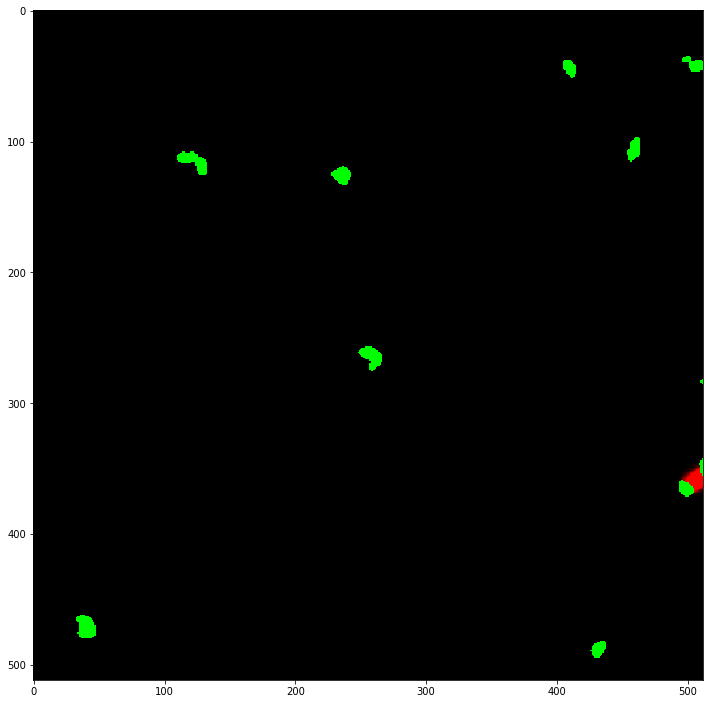

In [6]:
for (img, mask) in val_ds.shuffle(30).take(1):
    print(mask.dtype)
#     L = u_net.weighted_loss(mask, mask)
    M = mask[0,:,:,0]
    wc = u_net.balancing_weight_tf(M)
    dw = u_net.distance_weight(M.numpy(), w0=100, sigma=5.0)
    
    
    plt.figure(figsize=(12,16))
    b = np.zeros_like(M)
    plt.imshow(np.dstack([dw, M, b]))
#     plt.imshow(dw)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])

#     plt.subplot(1,3,2)
#     plt.imshow(M)

#     plt.subplot(1,3,3)
#     plt.imshow(dw)
    
#     print(L.shape)
    print((wc.numpy().min(), wc.numpy().max()))
    print((dw.min(), dw.max()))
    
#     plt.figure(figsize=(12,16))
    
#     for i, w in enumerate(L):
#         if i>2:
#             break
            
#         plt.subplot(3,3,3*i+1)
#         plt.imshow(img[i,:,:,0])

#         plt.subplot(3,3,3*i+2)
#         plt.imshow(mask[i,:,:,0])

#         plt.subplot(3,3,3*i+3)
#         plt.imshow(w)
#         print((w.numpy().min(), w.numpy().max()))
        


# Build the model

In [7]:
num_filters_list = [32, 64, 128, 256, 512]
model = u_net.Unet(num_filters_list, dynamic=True)

loss_fn = lambda x, y: u_net.weighted_loss(x, y, w0=100, sigma=5.0)
model.compile(optimizer='adam', loss=loss_fn, metrics=[u_net.dice_loss])

# plt.figure(figsize=(12,16))
# for i, (img, mask) in enumerate(train_ds.take(1)):
#     y_pred = model(img)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])
#     plt.subplot(1,3,2)
#     plt.imshow(mask[0,:,:,0])
#     plt.subplot(1,3,3)
#     plt.imshow(y_pred[0,:,:,0])
# plt.show()

## Train the model

In [8]:
model_tag = 'nucleus_weighted_bce2'
timestamp = '{}'.format(datetime.datetime.now()).split('.')[0].replace(':','_').replace(' ','_')
root_path = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation'
foler_name = model_tag + timestamp

# model weights
weights_path = os.path.join(root_path, 'models', foler_name, 'weights-{epoch:04d}.ckpt')
weights_dir = os.path.dirname(weights_path)
if not os.path.isdir(weights_dir):
    os.makedirs(weights_dir, exist_ok=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, monitor='val_dice_loss', 
                                        save_best_only=True, save_weights_only=True, verbose=1)
# tensorboard
log_dir = os.path.join(root_path, 'logs', foler_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir, exist_ok=True)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [9]:
history = model.fit(train_ds, epochs=50, 
                    steps_per_epoch=int(np.ceil(num_train_data / batch_size)),
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_data / batch_size)),
                    callbacks=[cp, tb])

W0416 07:38:04.685550 140231450072832 callbacks.py:1218] TensorBoard Callback will ignore `write_graph=True`when `Model.run_eagerly=True`.`


Epoch 1/50
68/69 [============================>.] - ETA: 3s - loss: 0.4848 - dice_loss: 0.7956
Epoch 00001: val_dice_loss improved from inf to 0.92304, saving model to /awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/nucleus_weighted_bce22019-04-16_07_38_00/weights-0001.ckpt
69/69 [==============================] - 330s 5s/step - loss: 0.4821 - dice_loss: 0.7935 - val_loss: 1.6477 - val_dice_loss: 0.9230
Epoch 2/50
68/69 [============================>.] - ETA: 3s - loss: 0.2180 - dice_loss: 0.5943
Epoch 00002: val_dice_loss improved from 0.92304 to 0.91871, saving model to /awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/nucleus_weighted_bce22019-04-16_07_38_00/weights-0002.ckpt
69/69 [==============================] - 315s 5s/step - loss: 0.2175 - dice_loss: 0.5935 - val_loss: 1.9825 - val_dice_loss: 0.9187
Epoch 3/50
68/69 [============================>.] - ETA: 3s - loss: 0.1556 - dice_loss: 0.4772
Epoch 00003: val_dice_loss improved from 0.91871 to 0.83858, savi

68/69 [============================>.] - ETA: 3s - loss: 0.0706 - dice_loss: 0.0968
Epoch 00024: val_dice_loss did not improve from 0.08116
69/69 [==============================] - 312s 5s/step - loss: 0.0706 - dice_loss: 0.0968 - val_loss: 0.2960 - val_dice_loss: 0.7043
Epoch 25/50
68/69 [============================>.] - ETA: 3s - loss: 0.0729 - dice_loss: 0.0991
Epoch 00025: val_dice_loss did not improve from 0.08116
69/69 [==============================] - 310s 4s/step - loss: 0.0728 - dice_loss: 0.0991 - val_loss: 0.1284 - val_dice_loss: 0.3816
Epoch 26/50
68/69 [============================>.] - ETA: 3s - loss: 0.0721 - dice_loss: 0.1021
Epoch 00026: val_dice_loss did not improve from 0.08116
69/69 [==============================] - 320s 5s/step - loss: 0.0723 - dice_loss: 0.1020 - val_loss: 0.0936 - val_dice_loss: 0.1220
Epoch 27/50
68/69 [============================>.] - ETA: 3s - loss: 0.0730 - dice_loss: 0.0953
Epoch 00027: val_dice_loss did not improve from 0.08116
69/69 [=

In [ ]:
import importlib
importlib.reload(u_net)

In [ ]:
for (x,y) in train_ds.take(1):
    u_net.bce_dice_loss(y,y)

### Plot training process

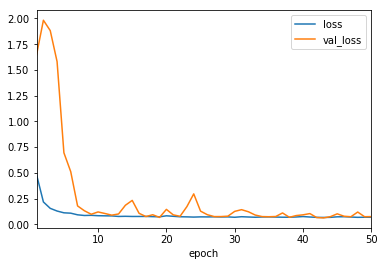

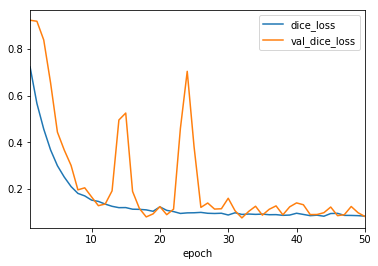

In [10]:
tr_process = pd.DataFrame.from_dict(history.history)
tr_process['epoch'] = np.array(range(1, tr_process.shape[0]+1))

tr_process.plot(x='epoch', y=['loss', 'val_loss'])
tr_process.plot(x='epoch', y=['dice_loss', 'val_dice_loss'])

### Or load the trained weights

In [ ]:
model_dir = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/2019-04-13_15_07_25'
latest = tf.train.latest_checkpoint(model_dir)
print(latest)
model.load_weights(latest)

In [ ]:
model.evaluate(val_ds, steps=int(np.ceil(num_val_data / batch_size)))

# Visualize performance

In [11]:
def overlay_mask(img, mask, mask_pred):
    """green: true, red: predicted"""
    I = np.uint8(img.numpy()*255.)
    I = cv2.cvtColor(I,cv2.COLOR_GRAY2RGB)
    
    M = np.uint8(mask.numpy()*255.)
    M_pred = np.uint8((mask_pred.numpy()>0.5) * 255.)
    
    im, contours, _ = cv2.findContours(M.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im_pred, contours_pred, _ = cv2.findContours(M_pred.copy(), 
                                                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    I1 = cv2.drawContours(I.copy(), contours, -1, (0,255,0), 1)
    I2 = cv2.drawContours(I.copy(), contours_pred, -1, (255,0,0), 1)
    I[:,:,1] = I1[:,:,1]
    I[:,:,0] = I2[:,:,0]
    
    return I

In [13]:
idx_to_plot = np.random.choice(num_val_data, 3)
result_folder = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/results'

if not os.path.isdir(result_folder):
    os.makedirs(result_folder)

# plt.figure(figsize=(12,16))

for i, (img, mask) in enumerate(val_ds):
    if i in idx_to_plot:
        y_pred = model(img)        
        for j in range(4):
            I = overlay_mask(img[j,:,:,0], mask[j,:,:,0], y_pred[j,:,:,0])
            fname = os.path.join(result_folder, '{}_{}.png'.format(i,j))
            cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))
            
#             plt.subplot(2,2,j+1)
#             plt.imshow(I)
            
    if i > max(idx_to_plot):
        break